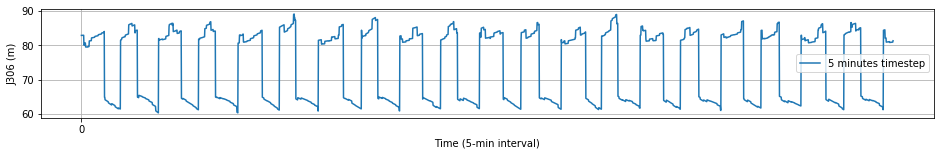

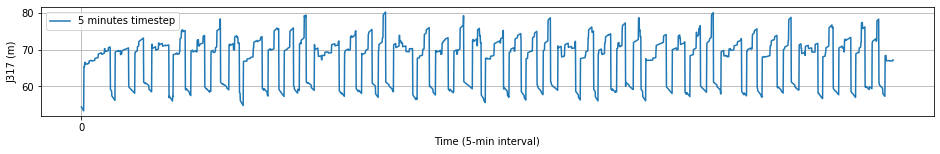

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import fileinput

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'   
    
path_in = 'data/'

sim_weeks = 1

# Data frame creation                
data_5_timestep = pd.read_csv('data/test_ctown_week_0_wntr.csv')    

#////////////////////////////// label, cat/non-cat variable definition     ///////////////////////////////

var_all = list(data_5_timestep.head(0))
#var_noncat = ['T1_LEVEL', 'T2_LEVEL', 'T3_LEVEL', 'T4_LEVEL', 'T5_LEVEL', 'T6_LEVEL', 'T7_LEVEL', 
#               'PU1_FLOW', 'PU2_FLOW', 'PU3_FLOW', 'PU4_FLOW', 'PU5_FLOW', 'PU6_FLOW', 'PU7_FLOW',
#               'PU8_FLOW', 'PU9_FLOW', 'PU10_FLOW', 'PU11_FLOW', 
#               'V2_FLOW', 
#               'J280_LEVEL', 'J269_LEVEL', 'J300_LEVEL', 'J256_LEVEL', 'J289_LEVEL', 'J415_LEVEL', 
#               'J302_LEVEL', 'J306_LEVEL', 'J307_LEVEL', 'J317_LEVEL', 'J14_LEVEL', 'J422_LEVEL']      
    
#var_cat =['PU1_STATUS', 'PU2_STATUS', 'PU3_STATUS', 'PU4_STATUS', 'PU5_STATUS', 'PU6_STATUS', 'PU7_STATUS', 'PU8_STATUS',
#          'PU9_STATUS','PU10_STATUS', 'PU11_STATUS',
#          'V2_STATUS'] 

#var_cat_noncat = var_noncat + var_cat
var_cat_noncat =['J306', 'J317']


label = ['Attack#01', 'Attack#02']


tanks = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7']

joints = ['J280', 'J269', 'J300', 'J256', 'J289', 'J415',
          'J302', 'J306', 'J307', 'J317', 'J14', 'J422']

xlabel_weeks = np.linspace(0, len(data_5_timestep), sim_weeks)
        
for var in (var_cat_noncat):
    plt.figure(figsize=(16, 2))    
    plt.plot(data_5_timestep[var], label="5 minutes timestep")
    plt.legend()
    plt.grid(True)
    
    if var in tanks:
        plt.ylabel(var + ' (m)')
    elif var in joints:
        plt.ylabel(var + ' (m)')
    elif var in flows:
        plt.ylabel(var + ' (L/S)')
    else:
        plt.ylabel(var)
        
    plt.xlabel('Time (5-min interval)')
    plt.xticks(xlabel_weeks), #plt.xlabel(label_x)
    plt.show()    

